# Importing the libraries

In [27]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchinfo import summary

In [28]:
# setting up torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)

device(type='cpu')

## Creating Transforms and Datasets

In [29]:
transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [30]:
# create Dataset
train_dataset = ImageFolder(root='DATASET/TRAIN', transform=transforms)
test_dataset = ImageFolder(root='DATASET/TEST', transform=transforms)

In [31]:
# checking dataset size
len(train_dataset), len(test_dataset)

(22564, 2513)

In [32]:
# create validation dataset from training set

train_size = int(0.8*len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
len(train_dataset), len(val_dataset)

(18051, 4513)

In [33]:
# create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

len(train_loader), len(val_loader), len(test_loader)

(565, 142, 79)

# Visualize Dataset

In [34]:
def visualize(dataloader):
  images, labels = next(iter(dataloader))
  grid = make_grid(images, nrow=8).permute(1,2,0).numpy()

  plt.figure(figsize=(16,16))
  plt.imshow(grid)
  plt.show()

In [35]:
# code a function that takes in entry train_loader and return only the images where the class is "O"
def get_class_images(dataloader, class_name):
    images = []
    for image, label in dataloader:
        if label == class_name:
            images.append(image)
    return images


In [36]:
# show me the structure of train_loader


train_loader

In [37]:
# display labels of training data
train_dataset.dataset.classes


['O', 'R']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


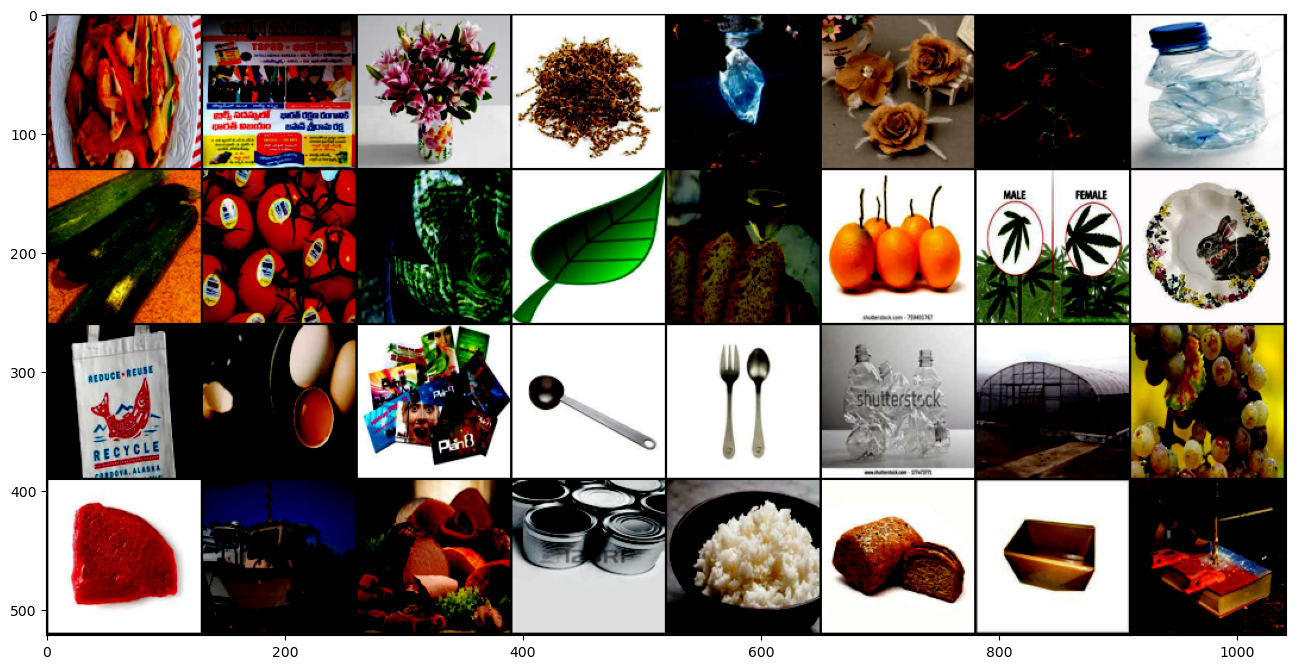

In [38]:
# visualize validation set
visualize(val_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


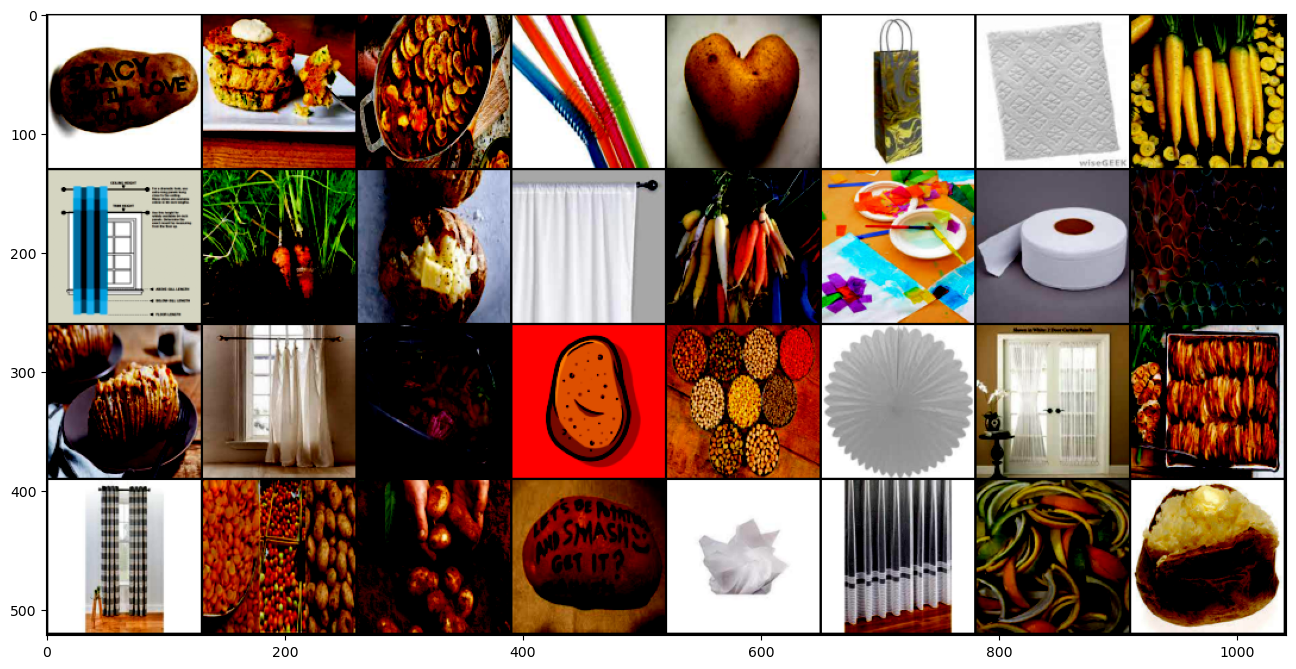

In [39]:
# visualize test set
visualize(test_loader)

# Creating Model

In [40]:
# create model

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.model = nn.Sequential(
            # first layer
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            # second layer
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            # third layer
            nn.Flatten(),
            nn.Linear(in_features=29*29*16, out_features=120),
            nn.ReLU(),

            # fourth layer
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),

            # output layer
            nn.Linear(in_features=84, out_features=2)
        )

    def forward(self, x):
        return self.model(x)


In [41]:
# get model info
model = LeNet()

# set model to device
model = model.to(device)

summary(model, input_size=(32, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [32, 2]                   --
├─Sequential: 1-1                        [32, 2]                   --
│    └─Conv2d: 2-1                       [32, 6, 124, 124]         456
│    └─ReLU: 2-2                         [32, 6, 124, 124]         --
│    └─AvgPool2d: 2-3                    [32, 6, 62, 62]           --
│    └─Conv2d: 2-4                       [32, 16, 58, 58]          2,416
│    └─ReLU: 2-5                         [32, 16, 58, 58]          --
│    └─AvgPool2d: 2-6                    [32, 16, 29, 29]          --
│    └─Flatten: 2-7                      [32, 13456]               --
│    └─Linear: 2-8                       [32, 120]                 1,614,840
│    └─ReLU: 2-9                         [32, 120]                 --
│    └─Linear: 2-10                      [32, 84]                  10,164
│    └─ReLU: 2-11                        [32, 84]                  --


# Train Model

In [42]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [43]:
# train model
epochs = 5

training_loss = []
validation_loss = []

for epoch in range(epochs):
    
    # Training phase
    model.train()
    epoch_train_loss = 0.0
    for images, labels in train_loader:
        # Move data to the appropriate device
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        train_loss = loss_fn(outputs, labels)
        
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        epoch_train_loss += train_loss.item() * images.size(0)  # Accumulate loss

    # Average training loss for the epoch
    epoch_train_loss /= len(train_loader.dataset)
    training_loss.append(epoch_train_loss)
    
    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    with torch.inference_mode():
        for val_images, val_labels in val_loader:
            # Move validation data to the appropriate device
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            val_outputs = model(val_images)
            val_loss = loss_fn(val_outputs, val_labels)
            epoch_val_loss += val_loss.item() * val_images.size(0)  # Accumulate loss
    
    # Average validation loss for the epoch
    epoch_val_loss /= len(val_loader.dataset)
    validation_loss.append(epoch_val_loss)

    # Print loss for the epoch
    print(f"Epoch: {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")


Epoch: 1/5, Training Loss: 0.4514, Validation Loss: 0.4060
Epoch: 2/5, Training Loss: 0.4140, Validation Loss: 0.3931
Epoch: 3/5, Training Loss: 0.3725, Validation Loss: 0.3617
Epoch: 4/5, Training Loss: 0.3420, Validation Loss: 0.4099
Epoch: 5/5, Training Loss: 0.3115, Validation Loss: 0.3806


# Visualize Losses

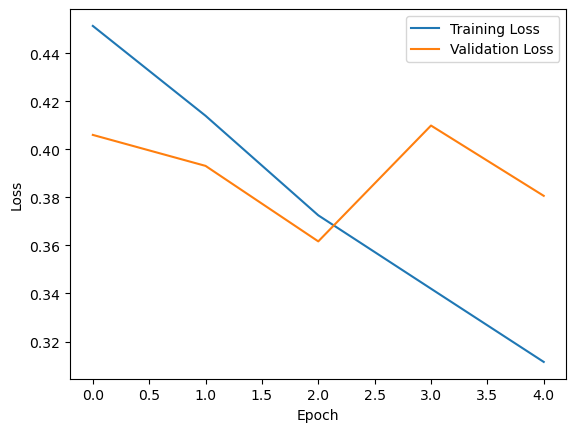

In [44]:
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test Model

In [45]:
# test model on trainng set
predicted_labels = []
actual_labels = []

model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

# Model Performace Stats

Model Accuracy: 87.66%
Model Precision: 87.66%
Model Recall: 87.66%
Model F1 Score: 87.64%
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1401
           1       0.87      0.84      0.86      1112

    accuracy                           0.88      2513
   macro avg       0.88      0.87      0.87      2513
weighted avg       0.88      0.88      0.88      2513



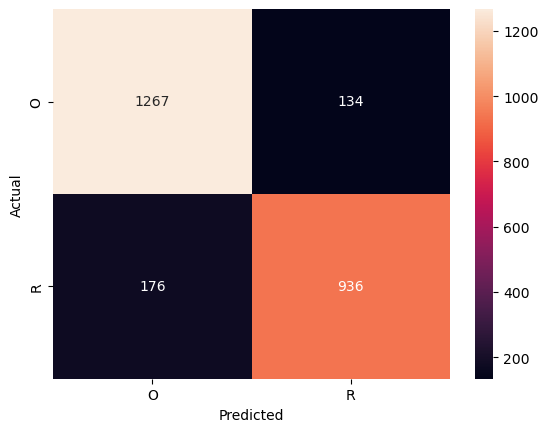

In [46]:
# print model accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# print precision

precision = precision_score(actual_labels, predicted_labels, average='weighted')
print(f"Model Precision: {precision * 100:.2f}%")

# print recall

recall = recall_score(actual_labels, predicted_labels, average='weighted')
print(f"Model Recall: {recall * 100:.2f}%")

# print f1 score

f1 = f1_score(actual_labels, predicted_labels, average='weighted')
print(f"Model F1 Score: {f1 * 100:.2f}%")

# print classification report

print(classification_report(actual_labels, predicted_labels))

# get confsion matrix and print actual labels

cm = confusion_matrix(actual_labels, predicted_labels)

class_names = test_loader.dataset.classes
# visualize confusion matruix using sns
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Save Model

In [ ]:
# save the model and load it again
torch.save(model.state_dict(), 'model.pth')

# load model
model = LeNet()

In [52]:
# load model
model = LeNet()
model.load_state_dict(torch.load('model.pth'))
model.eval()
# test the model on carrot.png
from PIL import Image
from torchvision.transforms import ToTensor

image = Image.open('carrot.png').convert('RGB')
image = transforms(image).unsqueeze(0).to(device)
output = model(image)

_, predicted = torch.max(output, 1)
predicted.item()

# get class name
class_names[predicted.item()]

# test the model on apple.png

'O'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


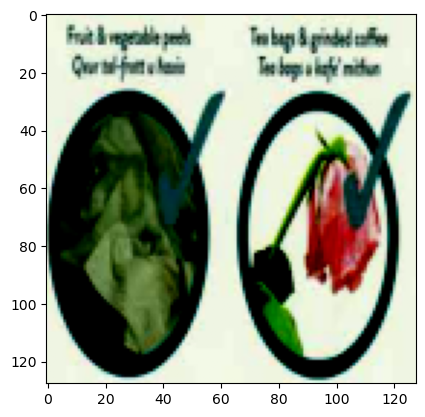

In [24]:
# show the images off the the "R" that has been predicted as "O"


model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
            if predicted[i] == 1 and labels[i] == 0:
                image = images[i].permute(1, 2, 0).cpu().numpy()
                plt.imshow(image)
                plt.show()
                break
        break

    